**Imports**

In [1]:
!pip install pytorch-ignite
!pip install torchsummary
import torch
import torchvision
import ignite
import os 
import torch
import torch.nn as nn
import torchvision.transforms as tf 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
%matplotlib inline
import os
import logging
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
dirc='../input/celeba-dataset/img_align_celeba'

**Data Processing**

In [4]:
workers=2
batch_size=128
image_size=64

In [5]:
dataset = ImageFolder(dirc,
                           transform=tf.Compose([
                               tf.Resize(image_size),
                               tf.CenterCrop(image_size),
                               tf.ToTensor()]))
test_dataset = torch.utils.data.Subset(dataset, torch.arange(3000))
# Create the dataloader

train_dataloader = idist.auto_dataloader(
    dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

2023-06-03 22:34:11,843 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset ImageFolder': 
	{'batch_size': 128, 'num_workers': 2, 'shuffle': True, 'drop_last': True, 'pin_memory': True}
2023-06-03 22:34:11,845 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'num_workers': 2, 'shuffle': False, 'drop_last': True, 'pin_memory': True}


**Displaying a batch of images**

In [6]:
def denormalized(img):
    return img * ms[1][0] + ms[0][0]

torch.Size([128, 3, 64, 64])


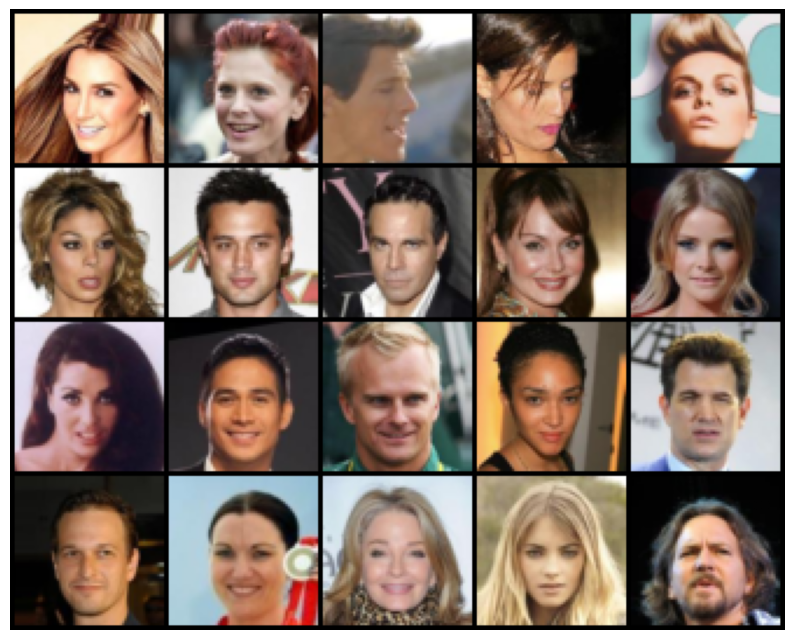

In [7]:
image,_ = next(iter(test_dataloader))
print(image.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(make_grid(image[:20],nrow=5).permute(1,2,0))

In [8]:
def deviceLoaderfunc(data,device):
    if isinstance(data,(list,tuple)):
        return [deviceLoaderfunc(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield deviceLoaderfunc(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:
dataloader = DeviceDataLoader(train_dataloader, device)

In [11]:
latent_size = 100

In [12]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<_Logger ignite.distributed.launcher.Parallel (WARNING)>

**Generator**

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 512 x 4 x 4 upsampled data

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
netG = idist.auto_model(Generator(latent_size))

In [15]:
idist.device()

device(type='cuda')

In [16]:
summary(netG, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

**Discriminator**

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
netD = idist.auto_model(Discriminator())
summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

**Defining loss function and optimizer**

In [19]:
criterion = nn.BCELoss()
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
)

In [20]:
fixed_noise = torch.randn(64, latent_size, 1, 1, device=idist.device())

**Initializing weights**

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Training**

In [22]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_size, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [23]:
trainer = Engine(training_step)

In [24]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(weights_init)
    netG.apply(weights_init)

**Append generator loss and Discriminator loss**

In [25]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

**Generated images**

In [26]:
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

**The Fréchet Inception distance (FID) and the inception score**

In [27]:
fid_metric = FID(device=idist.device())

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 91.0MB/s] 


In [28]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [29]:

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_size, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [30]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [31]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/100] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [32]:
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import ProgressBar

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

/opt/conda/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


**Training in parallel**

In [33]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=100)

In [34]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [1/100] Metric Scores
*   FID : 0.222651
*    IS : 1.857327


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [2/100] Metric Scores
*   FID : 0.082587
*    IS : 2.550336


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [3/100] Metric Scores
*   FID : 0.040387
*    IS : 2.035681


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [4/100] Metric Scores
*   FID : 0.040699
*    IS : 2.221487


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [5/100] Metric Scores
*   FID : 0.026680
*    IS : 2.139159


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [6/100] Metric Scores
*   FID : 0.027938
*    IS : 2.151771


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [7/100] Metric Scores
*   FID : 0.029192
*    IS : 2.270577


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [8/100] Metric Scores
*   FID : 0.022405
*    IS : 2.187788


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [9/100] Metric Scores
*   FID : 0.022172
*    IS : 2.143897


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [10/100] Metric Scores
*   FID : 0.024102
*    IS : 2.359117


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [11/100] Metric Scores
*   FID : 0.020001
*    IS : 2.246911


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [12/100] Metric Scores
*   FID : 0.019827
*    IS : 2.246840


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [13/100] Metric Scores
*   FID : 0.017251
*    IS : 2.169747


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [14/100] Metric Scores
*   FID : 0.017031
*    IS : 2.225662


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [15/100] Metric Scores
*   FID : 0.020338
*    IS : 2.298199


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [16/100] Metric Scores
*   FID : 0.017125
*    IS : 2.190920


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [17/100] Metric Scores
*   FID : 0.017728
*    IS : 2.221486


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [18/100] Metric Scores
*   FID : 0.019182
*    IS : 2.311977


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [19/100] Metric Scores
*   FID : 0.017735
*    IS : 2.192491


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [20/100] Metric Scores
*   FID : 0.017869
*    IS : 2.266788


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [21/100] Metric Scores
*   FID : 0.017613
*    IS : 2.339463


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [22/100] Metric Scores
*   FID : 0.017107
*    IS : 2.189041


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [23/100] Metric Scores
*   FID : 0.017359
*    IS : 2.276680


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [24/100] Metric Scores
*   FID : 0.021787
*    IS : 2.244261


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [25/100] Metric Scores
*   FID : 0.015887
*    IS : 2.355843


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [26/100] Metric Scores
*   FID : 0.012860
*    IS : 2.187149


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [27/100] Metric Scores
*   FID : 0.014470
*    IS : 2.152156


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [28/100] Metric Scores
*   FID : 0.019458
*    IS : 2.303207


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [29/100] Metric Scores
*   FID : 0.020185
*    IS : 2.279151


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [30/100] Metric Scores
*   FID : 0.014802
*    IS : 2.209757


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [31/100] Metric Scores
*   FID : 0.016692
*    IS : 2.208588


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [32/100] Metric Scores
*   FID : 0.014830
*    IS : 2.280826


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [33/100] Metric Scores
*   FID : 0.013389
*    IS : 2.284169


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [34/100] Metric Scores
*   FID : 0.013939
*    IS : 2.224164


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [35/100] Metric Scores
*   FID : 0.017328
*    IS : 2.224416


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [36/100] Metric Scores
*   FID : 0.012261
*    IS : 2.104793


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [37/100] Metric Scores
*   FID : 0.015614
*    IS : 2.225856


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [38/100] Metric Scores
*   FID : 0.017034
*    IS : 2.265161


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [39/100] Metric Scores
*   FID : 0.015435
*    IS : 2.145386


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [40/100] Metric Scores
*   FID : 0.019252
*    IS : 2.204271


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [41/100] Metric Scores
*   FID : 0.015412
*    IS : 2.227320


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [42/100] Metric Scores
*   FID : 0.018578
*    IS : 2.211375


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [43/100] Metric Scores
*   FID : 0.011180
*    IS : 2.136322


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [44/100] Metric Scores
*   FID : 0.017387
*    IS : 2.252261


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [45/100] Metric Scores
*   FID : 0.017018
*    IS : 2.313518


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [46/100] Metric Scores
*   FID : 0.017330
*    IS : 2.159361


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [47/100] Metric Scores
*   FID : 0.016462
*    IS : 2.268329


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [48/100] Metric Scores
*   FID : 0.015509
*    IS : 2.230445


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [49/100] Metric Scores
*   FID : 0.013784
*    IS : 2.231398


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [50/100] Metric Scores
*   FID : 0.016317
*    IS : 2.240699


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [51/100] Metric Scores
*   FID : 0.014755
*    IS : 2.252635


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [52/100] Metric Scores
*   FID : 0.022358
*    IS : 2.264143


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [53/100] Metric Scores
*   FID : 0.020728
*    IS : 2.308959


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [54/100] Metric Scores
*   FID : 0.015442
*    IS : 2.260609


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [55/100] Metric Scores
*   FID : 0.019288
*    IS : 2.269680


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [56/100] Metric Scores
*   FID : 0.016949
*    IS : 2.283962


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [57/100] Metric Scores
*   FID : 0.012577
*    IS : 2.237934


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [58/100] Metric Scores
*   FID : 0.013549
*    IS : 2.224711


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [59/100] Metric Scores
*   FID : 0.017436
*    IS : 2.182475


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [60/100] Metric Scores
*   FID : 0.013799
*    IS : 2.269286


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [61/100] Metric Scores
*   FID : 0.017609
*    IS : 2.276933


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [62/100] Metric Scores
*   FID : 0.017357
*    IS : 2.282813


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [63/100] Metric Scores
*   FID : 0.014412
*    IS : 2.228122


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [64/100] Metric Scores
*   FID : 0.018137
*    IS : 2.188121


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [65/100] Metric Scores
*   FID : 0.022075
*    IS : 2.256517


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [66/100] Metric Scores
*   FID : 0.016566
*    IS : 2.181827


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [67/100] Metric Scores
*   FID : 0.016087
*    IS : 2.201041


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [68/100] Metric Scores
*   FID : 0.015894
*    IS : 2.213974


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [69/100] Metric Scores
*   FID : 0.016882
*    IS : 2.216113


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [70/100] Metric Scores
*   FID : 0.016397
*    IS : 2.281474


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [71/100] Metric Scores
*   FID : 0.019354
*    IS : 2.357971


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [72/100] Metric Scores
*   FID : 0.018253
*    IS : 2.232355


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [73/100] Metric Scores
*   FID : 0.017791
*    IS : 2.210955


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [74/100] Metric Scores
*   FID : 0.012163
*    IS : 2.263281


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [75/100] Metric Scores
*   FID : 0.017226
*    IS : 2.279980


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [76/100] Metric Scores
*   FID : 0.032629
*    IS : 2.323831


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [77/100] Metric Scores
*   FID : 0.017164
*    IS : 2.251056


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [78/100] Metric Scores
*   FID : 0.021961
*    IS : 2.269673


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [79/100] Metric Scores
*   FID : 0.015329
*    IS : 2.200309


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [80/100] Metric Scores
*   FID : 0.024410
*    IS : 2.268479


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [81/100] Metric Scores
*   FID : 0.016520
*    IS : 2.239465


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [82/100] Metric Scores
*   FID : 0.018738
*    IS : 2.233456


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [83/100] Metric Scores
*   FID : 0.020156
*    IS : 2.266654


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [84/100] Metric Scores
*   FID : 0.018316
*    IS : 2.219895


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [85/100] Metric Scores
*   FID : 0.018253
*    IS : 2.190076


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [86/100] Metric Scores
*   FID : 0.015949
*    IS : 2.330047


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [87/100] Metric Scores
*   FID : 0.012793
*    IS : 2.160714


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [88/100] Metric Scores
*   FID : 0.017539
*    IS : 2.302493


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [89/100] Metric Scores
*   FID : 0.016606
*    IS : 2.266953


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [90/100] Metric Scores
*   FID : 0.029095
*    IS : 2.338109


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [91/100] Metric Scores
*   FID : 0.011628
*    IS : 2.202941


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [92/100] Metric Scores
*   FID : 0.019384
*    IS : 2.231071


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [93/100] Metric Scores
*   FID : 0.016139
*    IS : 2.248535


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [94/100] Metric Scores
*   FID : 0.013253
*    IS : 2.144603


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [95/100] Metric Scores
*   FID : 0.025025
*    IS : 2.364056


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [96/100] Metric Scores
*   FID : 0.014812
*    IS : 2.219689


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [97/100] Metric Scores
*   FID : 0.014209
*    IS : 2.205943


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [98/100] Metric Scores
*   FID : 0.014069
*    IS : 2.123598


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [99/100] Metric Scores
*   FID : 0.013975
*    IS : 2.276244


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [100/100] Metric Scores
*   FID : 0.016306
*    IS : 2.328707


**Generator and Discriminator loss curves**

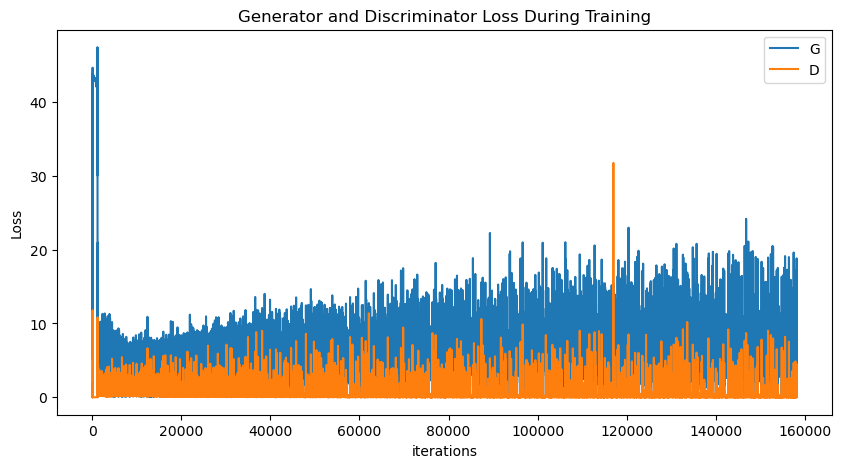

In [35]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

**FID and inception scores curves**

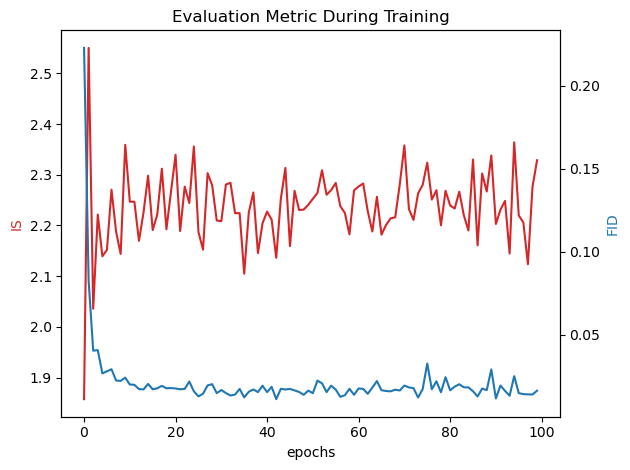

In [36]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

**Real Images vs Fake Images**

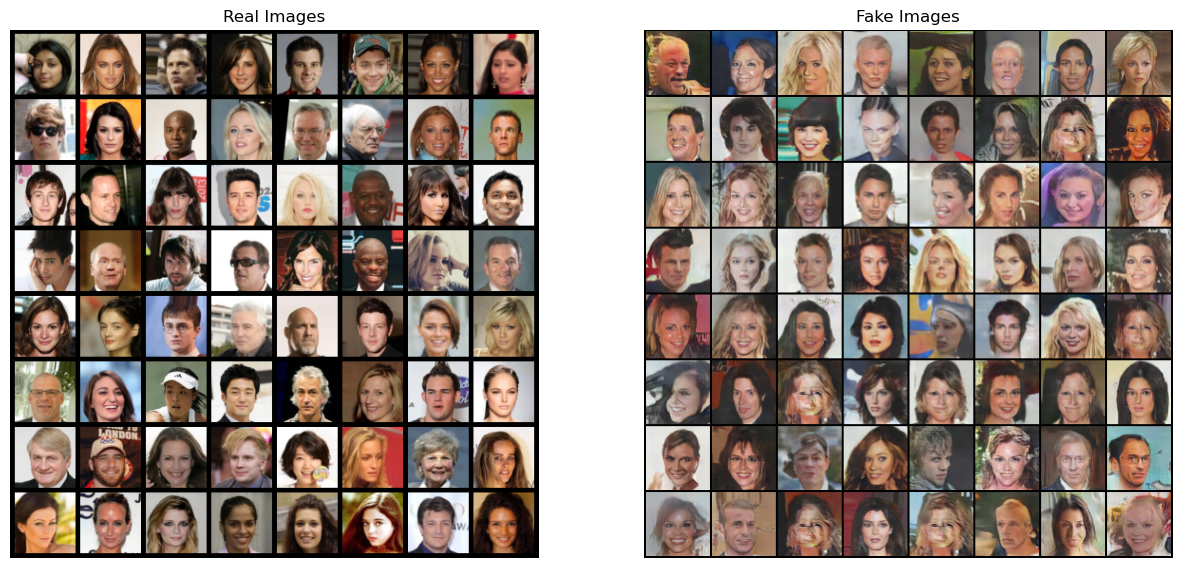

In [37]:
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))